Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Training Loss: 0.588208
Validation Loss: 0.616651, Accuracy: 85.46%, Precision: 0.86, Recall: 0.99, F1 Score: 0.92
Epoch 1 checkpoint saved at /content/drive/My Drive/FYP/VITModified_HQ3_20250503/epoch_1_vit_20250503.pth
Final model (epoch 1) saved at /content/drive/My Drive/FYP/VITModified_HQ3_20250503/final_model_vit_20250503.pth
New best model saved with accuracy: 85.46% at /content/drive/My Drive/FYP/VITModified_HQ3_20250503/best_model_vit_20250503.pth
Epoch [2/20], Training Loss: 0.504112
Validation Loss: 0.398390, Accuracy: 84.14%, Precision: 0.84, Recall: 1.00, F1 Score: 0.91
Epoch 2 checkpoint saved at /content/drive/My Drive/FYP/VITModified_HQ3_20250503/epoch_2_vit_20250503.pth
Final model (epoch 2) saved at /content/drive/My Drive/FYP/VITModified_HQ3_20250503/final_model_vit_20250503.pth
Epoch [3/20], Training Loss: 0.427653
Validation Loss: 0.407220, Accuracy: 84.14%, Precision: 0.84, Recall: 1.00, F1 Score: 0.91
Epoch 3 checkpoint saved at /content/drive/My Dr

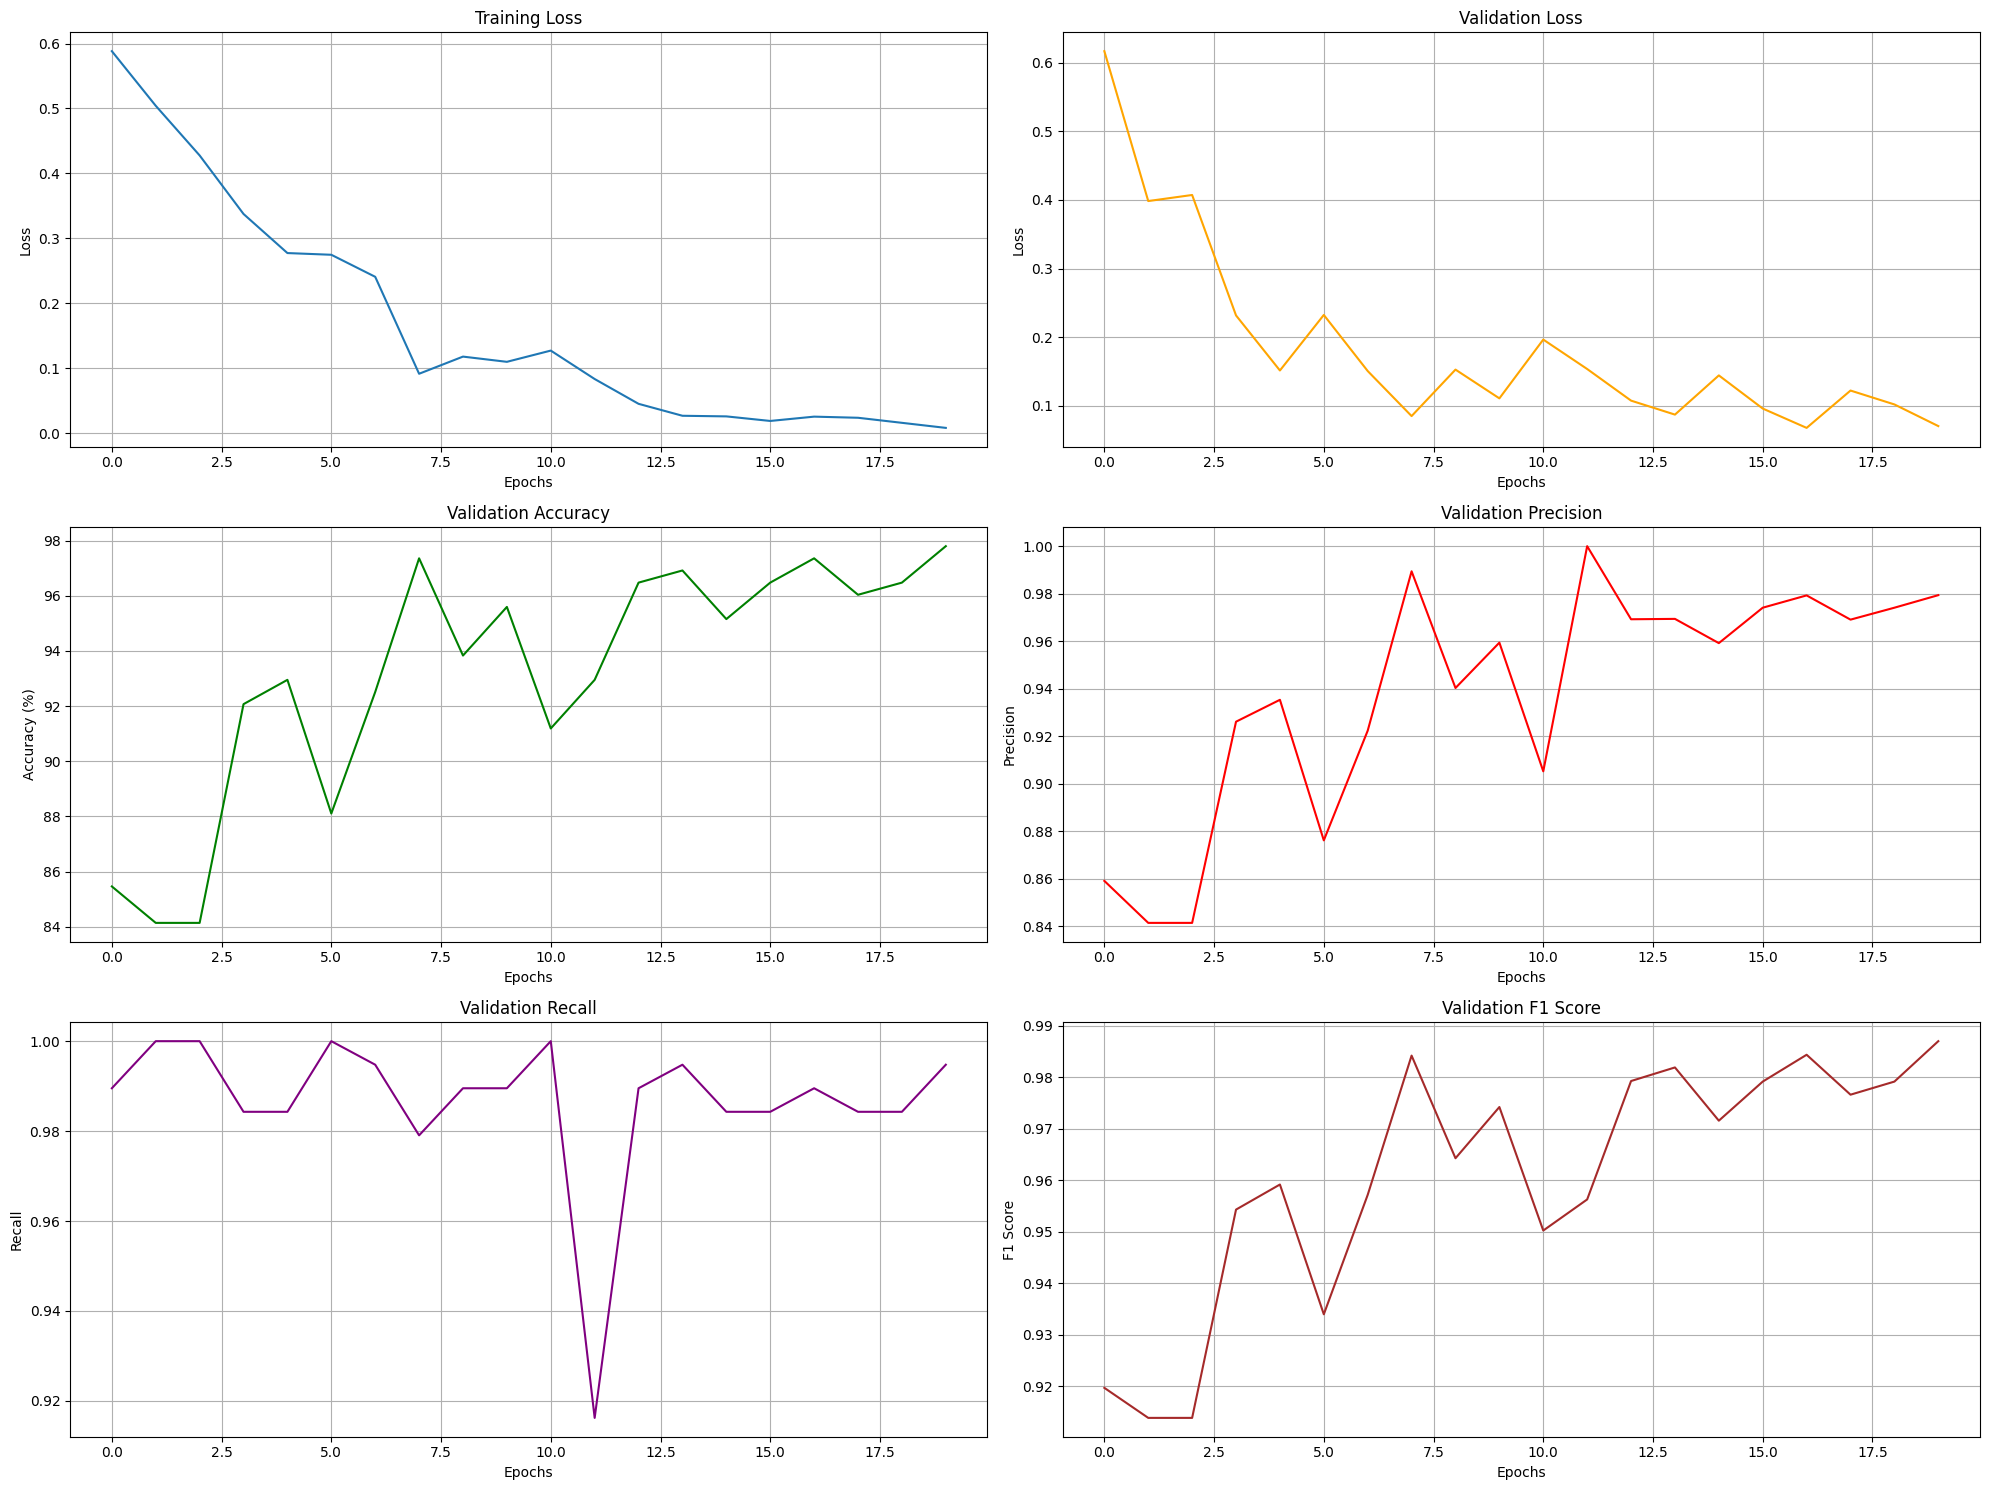

Training complete!
Test Loss: 0.002081, Test Accuracy: 100.00%
Test Precision: 1.00, Test Recall: 1.00, Test F1 Score: 1.00


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # For using pretrained Vision Transformer models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/VITModified_HQ3_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Typical input size for ViT models
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Use Pre-trained Vision Transformer (ViT) model and modify it for binary classification
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features

        self.vit.head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 2)
        )  # Modify the classifier to output 2 classes

    def forward(self, x):
        return self.vit(x)

# Initialize the ViT model
model = ViTModified().to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Validation function returning both loss and metrics
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')

    print(f'Validation Loss: {val_loss:.6f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')
    return val_loss, accuracy, precision, recall, f1

# Training loop with learning rate scheduler and checkpoint saving
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate and store training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.6f}")

        # Validation phase
        val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion)

        # Store validation metrics
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Step the scheduler on the validation accuracy
        scheduler.step(val_acc)

        # Save checkpoint after each epoch (epoch checkpoint)
        epoch_checkpoint_path = os.path.join(checkpoint_folder, f"epoch_{epoch+1}_vit_{date_str}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
        }, epoch_checkpoint_path)
        print(f"Epoch {epoch+1} checkpoint saved at {epoch_checkpoint_path}")

        # Save the "final" model at the end of every epoch (overwrites previous final model)
        final_model_path = os.path.join(checkpoint_folder, f"final_model_vit_{date_str}.pth")
        torch.save(model.state_dict(), final_model_path)
        print(f"Final model (epoch {epoch + 1}) saved at {final_model_path}")

        # Save the best model if the accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_vit_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    plt.figure(figsize=(20, 15))

    # Plot training loss
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    # Plot validation loss
    plt.subplot(3, 2, 2)
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(3, 2, 3)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    # Plot validation precision
    plt.subplot(3, 2, 4)
    plt.plot(val_precisions, label='Validation Precision', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Validation Precision')
    plt.grid(True)

    # Plot validation recall
    plt.subplot(3, 2, 5)
    plt.plot(val_recalls, label='Validation Recall', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Validation Recall')
    plt.grid(True)

    # Plot F1 score
    plt.subplot(3, 2, 6)
    plt.plot(val_f1s, label='Validation F1 Score', color='brown')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_folder, f"training_metrics_{date_str}.png"))
    plt.show()

    print("Training complete!")

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(loader)
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')

    print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {accuracy:.2f}%')
    print(f'Test Precision: {precision:.2f}, Test Recall: {recall:.2f}, Test F1 Score: {f1:.2f}')

    # Save test results
    with open(os.path.join(checkpoint_folder, f"test_results_{date_str}.txt"), "w") as f:
        f.write(f'Test Loss: {test_loss:.6f}\n')
        f.write(f'Test Accuracy: {accuracy:.2f}%\n')
        f.write(f'Test Precision: {precision:.2f}\n')
        f.write(f'Test Recall: {recall:.2f}\n')
        f.write(f'Test F1 Score: {f1:.2f}\n')

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)